<a href="https://colab.research.google.com/github/samj2199/Image-Classification-Project/blob/main/Wildlife_Img_Cls_Attempt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECOND ATTEMPT
# Title :- Wildlife Image Detection - Image Classification of Birds and Squirrels using CIFAR-10 Dataset - RESNET
# Motive :-This was done only to check if our methodology works good with a better and larger dataset (In reference to our custom Dataset i.e birds vs squirrels)

*   ## Members -    
                *   Surya Samarth J
                *   Jayanth Suryaprakash
                *   Riya Gaur

## Project Overview

Transitioning our focus to the CIFAR-10 dataset marks a pivotal evolution from our prior project, which was limited to a custom dataset of 500 bird and 500 squirrel images. The CIFAR-10 dataset, with its 60,000 images spanning 10 distinct classes, presents a more complex and varied challenge that better aligns with real-world applications.
Transitioning our focus to the CIFAR-10 dataset marks a pivotal evolution from our prior project, which was limited to a custom dataset of 500 bird and 500 squirrel images.

## Why this project?

This project explores the application of a customized ResNet architecture for the task of image classification on the CIFAR-10 dataset. The CIFAR-10 dataset, known for its diversity across 10 different classes of objects, provides a challenging yet rewarding benchmark for evaluating the performance of deep learning models in recognizing and distinguishing complex patterns in images.

## Goal

Our goal is to harness the power of convolutional neural networks (CNNs) to achieve high accuracy in classifying images into their respective categories. We emphasize the customization of the **ResNet model**, which is renowned for its deep layered structure and efficiency, to suit the specific requirements and nuances of the CIFAR-10 dataset.

Through meticulous experimentation and evaluation, we aim to push the boundaries of current image classification capabilities, contributing valuable insights and advancements to the field of computer vision and deep learning.




In [ ]:
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Method

The methodological advancements in this project are designed to leverage the complexity and diversity of the CIFAR-10 dataset effectively.

### Data Preprocessing and Loading
Unlike our previous project, where data variety was constrained, the CIFAR-10 dataset demanded a more robust preprocessing pipeline to normalize and augment data, addressing the intricate variations across a broader spectrum of images.

### Model Architecture

#### **ResNet Customization**
Building on the lessons learned from our initial foray with a simpler dataset, we customized the ResNet architecture with enhanced depth and adaptability to capture the nuanced features within CIFAR-10, a significant step up in complexity.

We adopt particularly a bottleneck version of the ResNet architecture, renowned for its deep layers and residual connections that facilitate the training of substantially deep neural networks optimizing both the computational resources and the model's performance.

#### **Implementation Highlights**
Our approach incorporates sophisticated data augmentation and normalization techniques, preparing the model to handle the CIFAR-10 dataset's variability and complexity more effectively than our previous project's simpler scope.

Key highlights of our implementation include the introduction of sequential and parallel convolutional pathways within the bottleneck blocks. This design choice allows for a more granular feature extraction, capturing a wide range of features from the input images.

### **Loss Function and Optimizer**
The shift to CIFAR-10 necessitated a reassessment of our loss function and optimizer choice, with an emphasis on strategies that optimize learning from a richer, more varied dataset.

In line with our objectives, we utilize the CrossEntropyLoss function for its effectiveness in classification tasks coupled with the Stochastic Gradient Descent (SGD) optimizer. This combination is chosen for its proven track record in achieving convergence in deep learning models.

### **Sanity Checks**
Sanity checks were expanded to ensure robustness and reliability in handling the increased diversity and potential challenges posed by the CIFAR-10 dataset.

Before proceeding to full-scale training, we perform a series of sanity checks to ensure the integrity of our dataset, the correct initialization of the model, and the responsiveness of the model to training on a subset of the data. These preliminary tests are vital for validating our experimental setup.



In [ ]:
#Downloading and Loading the CIFAR-10 dataset
def Load_cifar10_data(batch_size, root=os.path.join('CIFAR10_DATASET')):
    final_root = os.path.expanduser(root)

    #Normalizing the Dataset
    Transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    Transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    #Downloading the CIFAR10 dataset
    Train_set = torchvision.datasets.CIFAR10(root=final_root, train=True, download=True, transform=Transform_train)
    Test_set = torchvision.datasets.CIFAR10(root=final_root, train=False, download=True, transform=Transform_test)

    #loading the dataset and assign it to a variable
    Load_CIFAR_traindata =torch.utils.data.DataLoader(Train_set, batch_size, shuffle=True)
    Load_CIFAR_testdata =torch.utils.data.DataLoader(Test_set, batch_size, shuffle=False)
    return Load_CIFAR_traindata, Load_CIFAR_testdata

Transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
CIFAR10_testdata = torchvision.datasets.CIFAR10(root='Cifar', train=False, download=True, transform=Transform_test)

#load the function of the CIFAR-10 dataset to the train and test variable loader
Traindata_Loader, Testdata_Loader = Load_cifar10_data(batch_size=128, root=os.path.join('CIFAR10_DATASET'))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:

class bottleneck_resnet(torch.nn.Module):
    Extension_Net = 1
    def __init__(self, Channel_In, filter_channel, stride=1):
        super(bottleneck_resnet, self).__init__()
        self.convolutional_layer1 = torch.nn.Conv2d(Channel_In, filter_channel, kernel_size=3, stride=stride, padding=1, bias=True)
        self.normalization_layer1 = torch.nn.BatchNorm2d(filter_channel)
        self.convolutional_layer2 = torch.nn.Conv2d(filter_channel, filter_channel, kernel_size=3, stride=1, padding=1, bias=True)
        self.normalization_layer2 = torch.nn.BatchNorm2d(filter_channel)
        self.Pass_route = torch.nn.Sequential()
        if stride != 1 or Channel_In != self.Extension_Net * filter_channel:
            self.Pass_route = torch.nn.Sequential(torch.nn.Conv2d(Channel_In, self.Extension_Net * filter_channel, kernel_size=1, stride=stride, bias=True),
                                                  torch.nn.BatchNorm2d(self.Extension_Net * filter_channel))

    def forward(self, out):
        final_out = torch.nn.functional.relu(self.normalization_layer1(self.convolutional_layer1(out)))
        final_out = self.normalization_layer2(self.convolutional_layer2(final_out))
        final_out += self.Pass_route(out)
        final_out = torch.nn.functional.relu(final_out)
        return final_out

#creating the architecture of the RESNET
class ResNet(torch.nn.Module):
    #initialise the convolutional layer to append the hyperparameters
    def ResNet_conv_layer(self, conv_net, filter_channel, conv_net_int, stride):
        ST = [stride] + [1]*(conv_net_int-1)
        net_layer = []
        for stride in ST :
            net_layer.append(conv_net(self.Channel_In, filter_channel, stride))
            self.Channel_In = filter_channel * conv_net.Extension_Net
        return torch.nn.Sequential(*net_layer)

    def __init__(self, conv_net, conv_net_int, num_classes=10):
        super(ResNet, self).__init__()
        self.Channel_In = 64
        self.Conv_layer1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.batchnorm_layer1 = torch.nn.BatchNorm2d(64)
        self.Resnet_defined_layer1 = self.ResNet_conv_layer(conv_net, 64, conv_net_int[0], stride=1)
        self.Resnet_defined_layer2 = self.ResNet_conv_layer(conv_net, 128, conv_net_int[1], stride=2)
        self.Resnet_defined_layer3 = self.ResNet_conv_layer(conv_net, 256, conv_net_int[2], stride=2)
        self.Resnet_defined_layer4 = self.ResNet_conv_layer(conv_net, 512, conv_net_int[3], stride=2)
        self.final_layer = torch.nn.Linear(512 * conv_net.Extension_Net, num_classes)

    def forward(self, out):
        final_out = torch.nn.functional.relu(self.batchnorm_layer1(self.Conv_layer1(out)))
        final_out = self.Resnet_defined_layer1(final_out)
        final_out = self.Resnet_defined_layer2(final_out)
        final_out = self.Resnet_defined_layer3(final_out)
        final_out = self.Resnet_defined_layer4(final_out)
        final_out = torch.nn.functional.avg_pool2d(final_out, 4)
        final_out = final_out.view(out.size(0), -1)
        final_out = self.final_layer(final_out)
        return final_out

#defining the resnet Network type
def ResNet34_Architecture():
    return ResNet(bottleneck_resnet, [3, 4, 6, 3])

#Updating the weights of the network
Network_arch = ResNet34_Architecture()
#Initialize the Weights and display the Network architecture
def Initialise_weights(layer_weight):
    if type(layer_weight) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(layer_weight.weight)
Network_arch.apply(Initialise_weights)

ResNet(
  (Conv_layer1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Resnet_defined_layer1): Sequential(
    (0): bottleneck_resnet(
      (convolutional_layer1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (normalization_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (convolutional_layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (normalization_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Pass_route): Sequential()
    )
    (1): bottleneck_resnet(
      (convolutional_layer1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (normalization_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (convolutional_layer2): Conv2d(64, 64, kernel_size

In [ ]:
#enumerating testdata with batch index of source and the target
testdata_ex = enumerate(Testdata_Loader)
batch_idx, (Val_ex_data, Val_ex_targets) = next(testdata_ex)
#printing the shape of the indexed data
print(Val_ex_data.shape)

torch.Size([128, 3, 32, 32])


In [ ]:
#Initialization of Hyperparameters
#Number of epochs
EPOCHS = 40
#Batch size and the learning rate
batch_size= 32
Learning_rate= 0.1
#Loss Function
Loss_criterion_function = torch.nn.CrossEntropyLoss()
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#For storing the generated train and test accuracy and plotting
def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    x = range(len(hist['train_accuracy']))
    y1 = hist['train_accuracy']
    y2 = hist['test_accuracy']
    #plotting
    plt.plot(x, y1, label='train_accuracy')
    plt.plot(x, y2, label='test_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()
    #saving the generated outputs
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()


In [ ]:
#Test Accuracy and loss Evaluation
def Evaluate_Accuracy(dataset_eval_iteration, Network_arch, Loss_criterion_function, device=device):
  #Evaluate accuracy of a model on the testset
  #In evaluation mode, we will be using the dropout and normalization layers
  testset_initial=len(dataset_eval_iteration.dataset)
  test_loss=0
  test_accuracy=0
  Network_arch.eval()
  with torch.no_grad():
    for X, y in dataset_eval_iteration:
        #transfer the produced data to the device
        X = X.to(device)
        y = y.to(device)
        outputs = Network_arch(X)
        #calculating the test accuracy and loss and appending it
        test_loss += Loss_criterion_function(outputs,y).item()
        test_accuracy += (outputs.argmax(1) == y).type(torch.float).sum().item()
  test_accuracy = test_accuracy/testset_initial
  test_loss /= testset_initial
  return test_accuracy, test_loss

In [ ]:
#Cross validating the predicted values for plotting the confusion matrix and predict the correct and incorrect samples
def Cross_validate_predicted_data(Network_arch, dataset_eval_iteration):
    Data_pics_label = []
    Data_pics_val = []
    Network_arch.eval()
    for X, y in dataset_eval_iteration:
      X = X.to(device)
      y = y.to(device)
      prediction = Network_arch(X)
      with torch.no_grad():
            Final_predict = F.softmax(prediction, dim = -1)
            Data_pics_label.append(y.cpu())
            Data_pics_val.append(Final_predict.cpu())
    out1 = torch.cat(Data_pics_label)
    out2 = torch.cat(Data_pics_val)
    return out1, out2

## Experiments

Our experiments were meticulously crafted to explore the depth and breadth of the CIFAR-10 dataset, representing a significant escalation from our previous project's scope.

### Training Process and Hyperparameter Tuning
The training and hyperparameter tuning process was adapted to accommodate the CIFAR-10 dataset's complexity, focusing on achieving a delicate balance between model accuracy and generalization across a wider array of image types.

We explore various configurations, adjusting parameters such as batch size, learning rate, and the number of epochs, to balance the model's learning pace and generalization ability.

### Evaluation Metrics and Model Selection
A broader set of evaluation metrics, including accuracy, precision, recall, and F1 score, alongside the confusion matrix for an in-depth analysis of the model's performance across different classes was employed to thoroughly assess the model's performance, reflecting the diverse challenges presented by the CIFAR-10 dataset compared to the binary classification task of our prior project.


In [ ]:
#Training and Evaluating the model
#Training is performed on the train dataset
#Testing (Evaluation) is performed in the test dataset
#Train and evaluate the model using the device GPU or else with CPU
def training(Network_arch, Load_CIFAR10_traindata, Load_CIFAR10_testdata, Loss_criterion_function, EPOCHS, batch_size, device, Learning_rate=None):

    print('ResNet Architecture Training and Testing Begins!')
    Network_arch.to(device)
    #Initialization of the optimizer
    optimizer = optim.SGD(Network_arch.parameters(), lr=Learning_rate)
    #FOR CALCULATING THE EPOCHS
    for Epoch in range(EPOCHS):
        #Network is trained on the training mode
        Network_arch.train()
        cv = 0
        ep_start = time.time()
        Sum_training_Loss = torch.tensor([0.0], device=device)
        Sum_training_Accuracy = torch.tensor([0.0], device=device)
        #FOR CALCULATING THE TRAIN LOSS AND TRAIN ACCURACY
        for X, y in Load_CIFAR10_traindata:
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            conv_y = Network_arch(X)
            final_end_loss = Loss_criterion_function(conv_y, y)
            final_end_loss.backward()
            optimizer.step()
            with torch.no_grad():
                y = y.long()
                Sum_training_Loss += final_end_loss.float()
                Sum_training_Accuracy += (torch.sum((torch.argmax(conv_y, dim=1) == y))).float()
                cv += y.shape[0]
                final_loss = Sum_training_Loss/cv
                final_train_accuracy = Sum_training_Accuracy/cv
                #final_train_accuracy_out =final_train_accuracy.to('cpu').numpy()
        #FOR CALCULATING THE TEST ACCURACY and loss
        final_test_accuracy, final_test_loss = Evaluate_Accuracy(Load_CIFAR10_testdata, Network_arch, Loss_criterion_function, device)
        #print(f'Epoch_start_time: {train_test_Start_Time}')
        print('Epoch--> %d\t Train_Loss: %.4f\t Train_Accuracy: %.2f\t    Test_Loss: %.4f\t  Test_Accuracy: %.2f\t  Time_Duration: %.1f sec\t' % (Epoch + 1, final_loss, final_train_accuracy*100, final_test_loss, final_test_accuracy*100, time.time() - ep_start))
        #Storing and tracking the outputs and plotting
        train_hist = {}
        train_hist['train_accuracy'] = []
        train_hist['test_accuracy'] = []
        train_hist['train_accuracy'].append(final_train_accuracy)
        train_hist['test_accuracy'].append(final_test_accuracy)

#Training and evaluating the Network model
ResNet_History = training(Network_arch, Traindata_Loader, Testdata_Loader, Loss_criterion_function, EPOCHS, batch_size, device, Learning_rate)
print('ResNet Architecture Training and Testing Completed!')

ResNet Architecture Training and Testing Begins!
Epoch--> 1	 Train_Loss: 0.0144	 Train_Accuracy: 34.33	    Test_Loss: 0.0125	  Test_Accuracy: 43.17	  Time_Duration: 77.2 sec	
Epoch--> 2	 Train_Loss: 0.0104	 Train_Accuracy: 51.87	    Test_Loss: 0.0106	  Test_Accuracy: 55.18	  Time_Duration: 78.8 sec	
Epoch--> 3	 Train_Loss: 0.0083	 Train_Accuracy: 61.71	    Test_Loss: 0.0129	  Test_Accuracy: 49.04	  Time_Duration: 78.8 sec	
Epoch--> 4	 Train_Loss: 0.0068	 Train_Accuracy: 69.30	    Test_Loss: 0.0075	  Test_Accuracy: 68.02	  Time_Duration: 78.9 sec	
Epoch--> 5	 Train_Loss: 0.0057	 Train_Accuracy: 74.53	    Test_Loss: 0.0084	  Test_Accuracy: 67.27	  Time_Duration: 79.3 sec	
Epoch--> 6	 Train_Loss: 0.0050	 Train_Accuracy: 77.94	    Test_Loss: 0.0062	  Test_Accuracy: 75.96	  Time_Duration: 79.4 sec	
Epoch--> 7	 Train_Loss: 0.0044	 Train_Accuracy: 80.23	    Test_Loss: 0.0056	  Test_Accuracy: 76.11	  Time_Duration: 79.4 sec	
Epoch--> 8	 Train_Loss: 0.0040	 Train_Accuracy: 82.16	    Test_Loss: 

## Results and Analysis

The results underscore the substantial progress made from our initial project. The model demonstrates a marked improvement in accurately classifying a wide range of images, benefiting from the diverse and comprehensive nature of the CIFAR-10 dataset. Our analysis reveals insights into the model's performance across different classes, highlighting significant advancements in recognizing complex patterns and features.

However, we observe challenges in correctly classifying certain classes that share similar features, indicating areas for future improvement. Our analysis of the confusion matrix provides valuable insights into these aspects, highlighting specific instances of misclassification.

Going forward, we aim to refine our model further, exploring more advanced techniques such as attention mechanisms and ensemble methods to enhance its accuracy and reliability. Additionally, we plan to extend our methodology to more complex datasets, pushing the envelope of what's possible in image classification tasks.


In [ ]:
#getting the output of the tensor(weights)
with torch.no_grad():
  Network_arch.to('cpu')
  final_tensor_output = Network_arch(Val_ex_data)
#printing the output
print(final_tensor_output)

tensor([[ -4.6863,  -0.4969,   0.2437,  ...,  -3.8757,  -5.3899,  -2.6811],
        [  5.8069,  11.6311,  -8.5687,  ..., -10.5349,  28.9717,   1.8470],
        [  9.1200,   6.0869,  -4.8672,  ...,   0.0320,  19.5390,   0.6754],
        ...,
        [  3.6560,   2.1219,   1.2146,  ...,  -7.1848,  -2.5852,   4.3414],
        [ -0.2049,  -1.6365,  -4.1715,  ...,  -5.9177,  25.7238,   3.4215],
        [ -7.6751,  -4.5073,   1.0561,  ...,   3.1249,  -0.8388,  -3.9616]])


<ipython-input-17-f32b444800a7>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_tensor_output)


<Axes: ylabel='Density'>

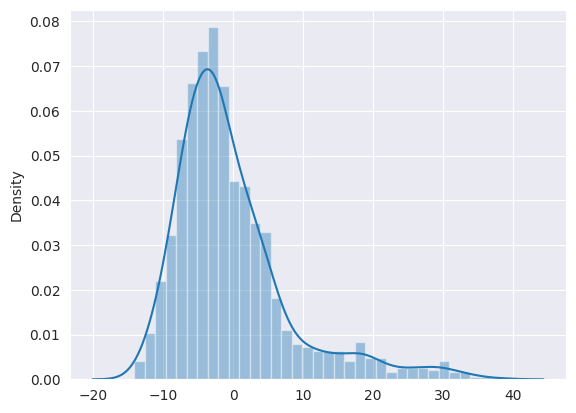

In [ ]:
#histogram for the tensor values
sns.distplot(final_tensor_output)

GROUNDTRUTH IMAGE


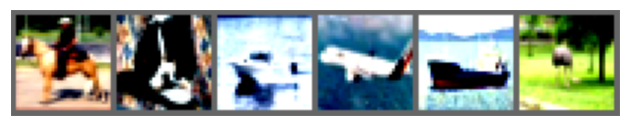

In [ ]:
#for testing our model after training, we have printed the classes of cifar-10 data for the groundtruth image
#In the evaluation phase we printed the classes of cifar-10 data with their predicted class
#we compare how correctly it predicted the classes between orginal and the predicted data
CIFAR10_Class = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')
device =torch.device('cpu')
for X, y in Testdata_Loader:
  X = X[:6]
  y = y[:6]
  def imshow(figure):
    figure = figure/2+0.1+0.1+0.2
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.imshow(np.transpose(figure.numpy(), (1,2,0)))
    plt.show()
#Plotting the Groundtruth image
center = "GROUNDTRUTH IMAGE"
print("{center:^10}".format(center=center))
imshow(make_grid(X))

In [ ]:
#Getting the predicted classes
Final_Out = Network_arch(X)
_, prediction = torch.max(Final_Out, 1)
#printing the classes of groundtruth data
print('Orginal images classes: ',' '.join(CIFAR10_Class[y[GT_data_out]] for GT_data_out in range(6)))
#printing the classes of prediction data
print('Predicted images classes: ',' '.join(CIFAR10_Class[prediction[Pred_data_out]] for Pred_data_out in range(6)))

Orginal images classes:  horse dog ship plane ship bird
Predicted images classes:  horse dog ship plane ship bird


In [ ]:
#Calculating the induvidual accuracy of Each classes defined
accurate_class_pred = list(range(10))
Combined_class_accurate = list(range(10))
with torch.no_grad():
    for X, y in Testdata_Loader:
      X = X.to(device)
      y = y.to(device)
      Final_Out = Network_arch(X)
      _, Induvidual_class_prediction = torch.max(Final_Out, 1)
      CIF_out = (Induvidual_class_prediction == y)
      for Induvidual_out in range(6):
        accurate_class_pred[y[Induvidual_out]] += CIF_out[Induvidual_out].item()
        Combined_class_accurate[y[Induvidual_out]] += 1
#Printing the accuracy of Each classes
for Induvidual_class_accuracy in range(10):
  print('Accuracy of %5s : %d %%' % (CIFAR10_Class[Induvidual_class_accuracy], accurate_class_pred[Induvidual_class_accuracy] / Combined_class_accurate[Induvidual_class_accuracy] *100))

Accuracy of plane : 90 %
Accuracy of   car : 97 %
Accuracy of  bird : 83 %
Accuracy of   cat : 58 %
Accuracy of  deer : 89 %
Accuracy of   dog : 87 %
Accuracy of  frog : 90 %
Accuracy of horse : 87 %
Accuracy of  ship : 98 %
Accuracy of truck : 92 %


In [ ]:
#Seperating the correct and incorrect predictions and appending it to a seperate list
Correct_Data = []
Incorrect_Data = []
Label_for_pic, Prediction = Cross_validate_predicted_data(Network_arch, Testdata_Loader)
Predicted_label = torch.argmax(Prediction, 1)
CIFAR10_Classes = CIFAR10_testdata.classes
Accurate_prediction = torch.eq(Label_for_pic, Predicted_label)
for i, j, Correct_data_prediction in zip(Label_for_pic, Prediction, Accurate_prediction):
    if Correct_data_prediction:
      Correct_Data.append((i, j))
    else:
      Incorrect_Data.append((i, j))
#Randomly sorting the samples
Correct_Data.sort(key = lambda Correct_samples: torch.max(Correct_samples[1], -1).values)
Incorrect_Data.sort(key = lambda Incorrect_samples: torch.max(Incorrect_samples[1], -1).values)

In [ ]:
#Examples of Correct Prediction
def Correct_Prediction(Correct_label_predict, CIFAR10_Classes):
    for Sample in range(1*5):
        Correct_Label, Prediction = Correct_label_predict[Sample]
        Correct_pred, Correctly_predicted_label = torch.max(Prediction, -1)
        Original_class = CIFAR10_Classes[Correct_Label]
        Correctly_Predicted_class = CIFAR10_Classes[Correctly_predicted_label ]
        print(f'Orginal images class     :  {Original_class}')
        print(f'Predicted images class   :  {Correctly_Predicted_class}')
Correct_Prediction(Correct_Data, CIFAR10_Classes)

Orginal images class     :  bird
Predicted images class   :  bird
Orginal images class     :  horse
Predicted images class   :  horse
Orginal images class     :  horse
Predicted images class   :  horse
Orginal images class     :  deer
Predicted images class   :  deer
Orginal images class     :  bird
Predicted images class   :  bird


In [ ]:
#Examples of Incorrect Prediction
def Incorrect_Prediction(Incorrect_label_predict, CIFAR10_Classes):
    for Sample in range(1*5):
        Incorrect_Label, Prediction = Incorrect_label_predict[Sample]
        Incorrect_pred, Incorrectly_predicted_label = torch.max(Prediction, -1)
        Original_class = CIFAR10_Classes[Incorrect_Label]
        Incorrectly_Predicted_class = CIFAR10_Classes[Incorrectly_predicted_label ]
        print(f'Orginal images class     :  {Original_class}')
        print(f'Predicted images class   :  {Incorrectly_Predicted_class}')
Correct_Prediction(Incorrect_Data, CIFAR10_Classes)

Orginal images class     :  cat
Predicted images class   :  dog
Orginal images class     :  airplane
Predicted images class   :  bird
Orginal images class     :  bird
Predicted images class   :  deer
Orginal images class     :  truck
Predicted images class   :  frog
Orginal images class     :  dog
Predicted images class   :  deer


## Conclusion

This project marks a significant milestone in the field of image classification, showcasing a notable transition from an initial exploration with a custom dataset to employing a customized ResNet architecture on the CIFAR-10 dataset. The evolution from preprocessing a simpler dataset to tackling the complexity and diversity of CIFAR-10 has furnished us with profound insights into the intricacies and challenges of analyzing high-dimensional visual data.

We've demonstrated that through careful architectural adjustments and methodical hyperparameter tuning, it's feasible to achieve remarkable accuracy across multiple categories. This endeavor not only enriches the academic discourse surrounding image classification but also lays down the groundwork for practical applications that demand accurate and dependable image classification systems. The methodologies honed and the lessons garnered throughout this project harbor potential for significant impacts on future research and practical applications in machine learning and computer vision.

By broadening our horizons and embracing the CIFAR-10 dataset, we have ventured into more complex classification tasks, unearthing valuable insights that steer us closer to applications in real-world scenarios. This progression underscores the pivotal role of dataset diversity in cultivating robust models and establishes a new benchmark for our forthcoming ventures in the realm of image classification.

Reflecting on the journey we have undertaken, we are inspired by the potential that lies in exploring advanced neural network architectures and expanding our focus to larger and more varied datasets. Our continued drive for knowledge and a desire to contribute meaningful advancements to the field of deep learning fuel our anticipation for the future. The path ahead is rife with opportunities for innovation, promising to elevate the capabilities of image classification systems further and bridge the gap between theoretical research and real-world application.


## CIFAR Dataset Advantages over Custom Dataset

The transition from a custom-curated dataset, comprising 500 images of birds and 500 images of squirrels, to the CIFAR-10 dataset represents a pivotal shift in our approach to image classification. This change brings forth a multitude of advantages that significantly impact the project's scope, model training, and potential applications. Here, we delve into the core benefits of employing the CIFAR-10 dataset:

### Enhanced Dataset Complexity and Diversity
- **Richer Feature Space:** CIFAR-10, with its 60,000 images across 10 distinct classes, introduces a more complex and varied feature space. This diversity enables our models to learn a broader spectrum of image features, translating into improved classification capabilities that are crucial for handling real-world data variability.

- **Challenge and Robustness:** The varied backgrounds, poses, and occlusions present in CIFAR-10 challenge the model in ways a smaller dataset cannot. Training on CIFAR-10 fosters the development of more robust models capable of generalizing from the training data to accurately classify unseen images, a critical factor for real-world applications.

### Benchmarking and Validation
- **Standardized Evaluation:** CIFAR-10 serves as a benchmark dataset in the machine learning community, providing a standardized framework for evaluating and comparing model performance. This enables a more meaningful assessment of our models' capabilities and highlights areas for improvement, offering insights that are less apparent when using a custom-curated dataset.

- **Reproducibility and Community Engagement:** Using a widely recognized dataset facilitates the reproduction of our results by other researchers, fostering community engagement and collaborative advancements in the field. It also allows for direct comparison with state-of-the-art models, driving innovation and improvement.

### Scalability and Future Research
- **Foundation for Scalability:** The complexity and size of CIFAR-10 prepare us for future projects involving even larger datasets, such as CIFAR-100 or ImageNet. This experience is invaluable for scaling our methodologies and models to tackle more ambitious image classification tasks.

- **Exploration of Advanced Techniques:** The challenges posed by CIFAR-10 encourage the exploration of advanced machine learning techniques and model architectures. This includes experimenting with data augmentation, transfer learning, and ensemble methods, paving the way for breakthroughs in model accuracy and efficiency.

### Real-World Application Readiness
- **Closer to Real-World Scenarios:** The diversity and complexity of CIFAR-10 more accurately mirror the challenges encountered in real-world image classification tasks. Models trained on CIFAR-10 are better equipped to deal with the unpredictability and variety of images outside laboratory conditions, making them more applicable and valuable for practical solutions.

In summary, the CIFAR-10 dataset substantially enriches our project by introducing a higher level of complexity, diversity, and realism compared to the custom-curated dataset of birds and squirrels. This transition not only enhances our models' performance and robustness but also aligns our research with broader, more challenging real-world applications, setting a solid foundation for future advancements in the domain of image classification.
